In [165]:
# !pip install mne

In [166]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from mne import read_evokeds
import mne
from ipywidgets import interactive

In [117]:
eeg_data = loadmat('data/sampleEEGdata.mat')

In [140]:
# data atrributes
fields = list(eeg_data['EEG'][0].dtype.names)
print(fields)

['setname', 'filename', 'filepath', 'subject', 'group', 'condition', 'session', 'comments', 'nbchan', 'trials', 'pnts', 'srate', 'xmin', 'xmax', 'times', 'data', 'icaact', 'icawinv', 'icasphere', 'icaweights', 'icachansind', 'chanlocs', 'urchanlocs', 'chaninfo', 'ref', 'event', 'urevent', 'eventdescription', 'epoch', 'epochdescription', 'reject', 'stats', 'specdata', 'specicaact', 'splinefile', 'icasplinefile', 'dipfit', 'history', 'saved', 'etc', 'spedata']


In [182]:
srate = eeg_data['EEG']['srate'][0][0][0][0]

### Plot of the electrode positions

In [ ]:
labels = list(np.hstack(eeg_data['EEG']['chanlocs'][0][0]['labels'][0]))

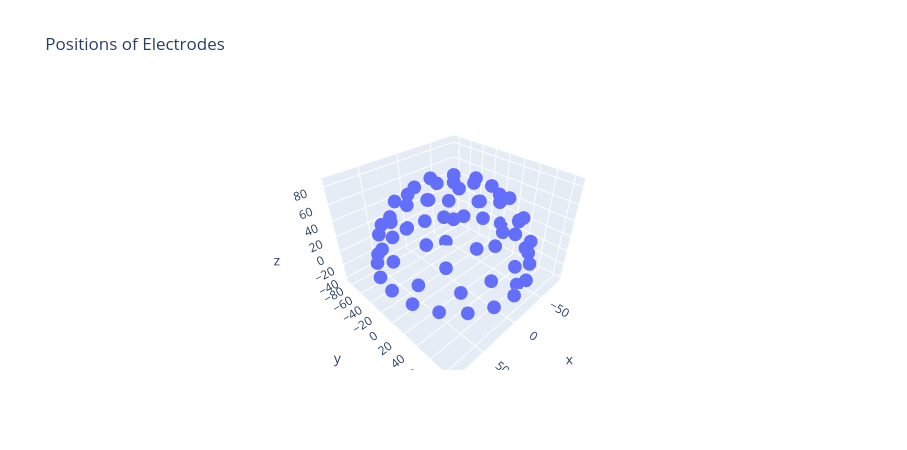

In [144]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=np.hstack(eeg_data['EEG'][0][0][21][0]['X'])[0], 
                           y=np.hstack(eeg_data['EEG'][0][0][21][0]['Y'])[0], 
                           z=np.hstack(eeg_data['EEG'][0][0][21][0]['Z'])[0], 
                           text=labels,
                           mode='markers'))
fig.update_layout(title='Positions of Electrodes')
fig.show()

### Event-Related Potential (ERP)

In [226]:
# average of the signal among all trials
erp = eeg_data['EEG']['data'][0][0].mean(axis=2)
times = eeg_data['EEG']['times'][0][0][0]

In [227]:
def plot_erp(erp_signal, time_vector, channel, time_range=None):
    
    assert channel in labels, "Check your channel name"
    
    idx = labels.index(channel)
    
    plt.figure(figsize=(10,4))
    plt.plot(time_vector, erp_signal[idx,:])
    if time_range:
        plt.xlim(time_range)
    plt.title(f"Event-Related Potential for the channel {channel}")
    plt.xlabel('Time (ms)')
    plt.ylabel('Signal (microV)')
    plt.plot()

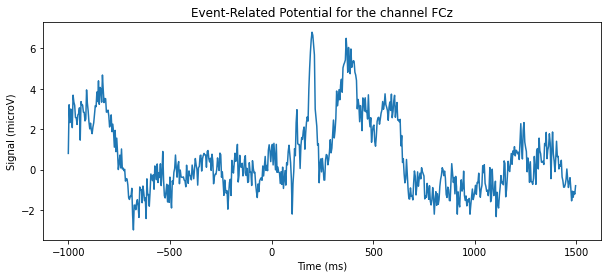

In [228]:
plot_erp(erp_signal=erp, 
         time_vector=times, 
         channel='FCz')

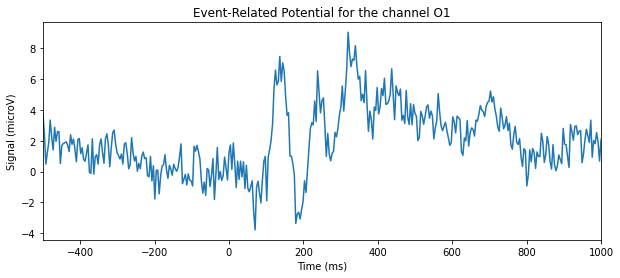

In [229]:
plot_erp(erp_signal=erp, 
         time_vector=times, 
         channel='O1',
         time_range=[-500, 1000])

### Topographical Maps

In [230]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
info = mne.create_info(ch_names=labels, 
                       sfreq=srate,
                       ch_types='eeg')

In [231]:
evoked = mne.EvokedArray(erp, info)
evoked.set_montage(biosemi_montage)

<Evoked | '' (average, N=1), [0, 2.4961] sec, 64 ch, ~500 kB>

In [232]:
check_ch = ['Oz', 'Fpz', 'T7', 'T8']
ch_idx = [evoked.ch_names.index(ch) for ch in check_ch]
pos = np.stack([evoked.info['chs'][idx]['loc'][:3] for idx in ch_idx])

x = pos[0, 0]
y = pos[-1, 1]
z = pos[:, -1].mean()
radius = np.abs(pos[[2, 3], 0]).mean()

In [251]:
def plot_topomap(time, style):
    
    sphere = None
    if style == 1:
        sphere = (x, y, z, radius)
    
    time2plot = time # in ms
    idx = np.argmin(np.abs(times - time2plot)) # time to index
    
    plt.figure(figsize=(8,8))
    plt.title(f'ERP from {time} (ms)')
    mne.viz.plot_topomap(data=evoked.data[:,idx], 
                         pos=evoked.info,
                         names=labels,
                         show_names=True,
                         sphere=sphere)
       
    plt.show()

In [252]:
# style 0 means MNE style, 1 - EEGLAB style
interactive_plot = interactive(
    plot_topomap, 
    time=(int(times.min()), int(times.max()), 1),
    style=(0,1,1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=248, description='time', max=1496, min=-1000), IntSlider(value=0, descri…